{'k': 1.5, 'D': 0.2, 'v': 1, 'tau': 0.8, 'R': 0.3, 'label': 'default'}

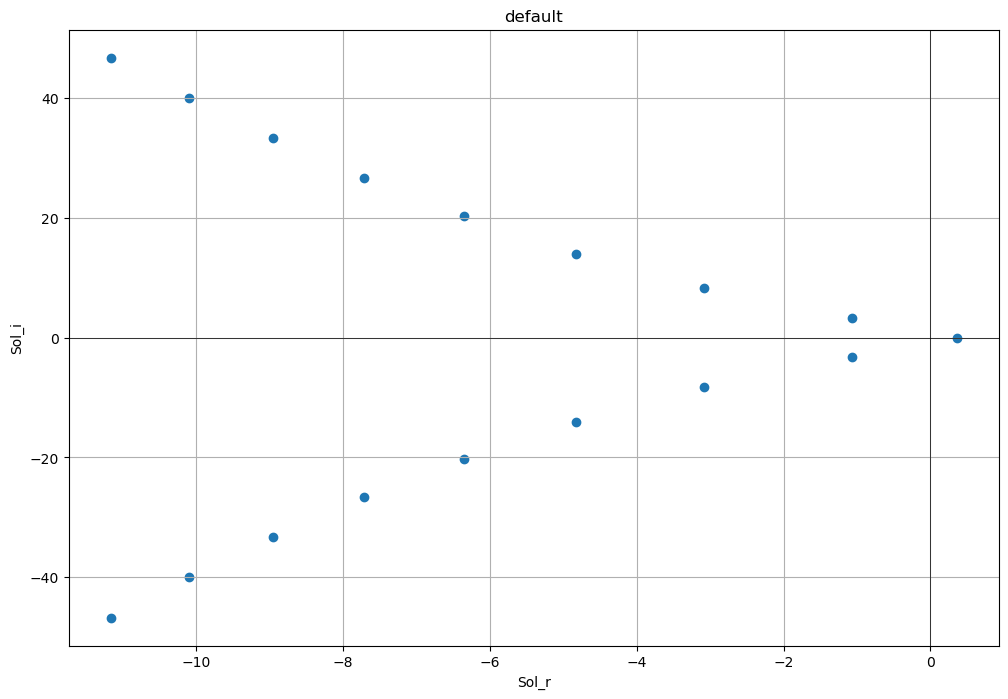

{'par': {'k': 1.5; 'D': 0.2; 'v': 1; 'tau': 0.8; 'R': 0.3; 'label': 'default'}; 'guess_range': ([-20; 5; 5]; [0; 50; 25]); 'tols': (1e-09; 1e-06; 4)}


In [1]:
import os
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import scipy.signal as signal
import scipy.linalg as lina
import matplotlib.cm as cm
# Get the viridis colormap
# my_cmap = cm.get_cmap('viridis')


# Get the directory where the current script is located
script_directory = os.getcwd()

# Change the current working directory to the script's directory
os.chdir(script_directory)

# Now the CWD is the same as the script's directory
# print("New Current Working Directory:", os.getcwd())

default_pars = obtain_default_pars('pars_list.csv')
# display(default_pars)

pars_list = create_custom_pars_list('pars_list.csv')
par = default_pars
# par = pars_list[0] # between 0 - 3; 1 is good; 3 to compare
display(par)

path_maker = par['label']
path = f"CSV/{path_maker}.csv"

if not os.path.exists(path):
    guess = {
        'guess_range_real':[-20,5,5],
        'guess_range_imag':[0,50,25]
    }
    save_dataframe_to_csv(*find_eig(par, **guess, round_sig_digits=4, tol_is_sol=1e-6, max_iter=200), 'CSV')
# else:
    # print("Solution has already been saved in the appropriate location.")

df, label, metadata = plot_single_df(
        path, filter=True,
        real_lower_bound=-40, real_upper_bound=5, imag_lower_bound=-500, imag_upper_bound=500
)
n_lambdas = len(df)
# display(df.head(n_lambdas))

from scipy.integrate import quad

lambdas = []
for index, row in df.head(n_lambdas).iterrows():
    l = complex(row['Sol_r'], row['Sol_i'])
    # print(f'lambda_{index+1} = {l}')
    lambdas.append(l)

normal_coefs = []
for n in range(n_lambdas):
    l = lambdas[n]
    
    i_phi = quad(eig_fun_mul_0,0,1,args=(par, l),complex_func=True)[0]
    b_phi = np.sqrt(1/i_phi)
    
    i_psi = quad(eig_fun_mul_1,0,1,args=(par, l, [b_phi, 1]),complex_func=True)[0]
    b_psi = (1/i_psi)
    
    b = (b_phi, b_psi.conjugate())
    normal_coefs.append(b)
    
    # print(f'normal_coef_phi_{n+1} = {complex(round(normal_coefs[n][0].real,4),round(normal_coefs[n][0].imag,4))}')
    # print(f'normal_coef_psi_{n+1} = {complex(round(normal_coefs[n][1].real,4),round(normal_coefs[n][1].imag,4))}')
    # print()

In [2]:
from scipy.integrate import solve_ivp
import plotly.graph_objs as go

N_zeta = 100
zeta = np.linspace(0,1,N_zeta)
dz = zeta[1]
phi_1_0 = init_cond_func_1(zeta)
phi_2_0 = init_cond_func_2(zeta, par)
x0 = np.array([phi_1_0, phi_2_0])

In [3]:
t_end = 8
N_t_d = 5*t_end

n_modes=3

In [4]:
t_eval_d = np.linspace(0,t_end,N_t_d+1)
s = 2/t_eval_d[1]
# G, S, S_u = G_S_Su(zeta, s, par, q_ctrl, N, r_ctrl, lambdas, n_modes, normal_coefs)
print(f't_eval_d = {t_eval_d[0]}, {t_eval_d[1]}, ... , {t_eval_d[-1]}')
# find_smallest_r(G, r_ctrl, 0, 5*r_ctrl)

t_eval_d = 0.0, 0.2, ... , 8.0


In [5]:
N = 9
q_ctrl = 1
r_ctrl = 675

u_limits = [0,0.15]
# y_limits = [-0.2,0.2]

G, S, S_u = G_S_Su(zeta, s, par, q_ctrl, N, r_ctrl, lambdas, n_modes, normal_coefs)

In [6]:
import quadprog
x_MPC = []
U_MPC = []
results_MPC = []
x_MPC.append(x0)
for i in range(len(t_eval_d)):
    G, a, C, b, meq = MPC_matrix_build(
            x_MPC[i], s, par, 
            lambdas, normal_coefs, q_ctrl, G, S, S_u,
            n_modes=n_modes, N=N,
            u_limits=u_limits, y_limits=(-1000, 1000),
            meq=1
        )
    # display(G, a, C, b, meq)
    results_MPC.append(quadprog.solve_qp(G, a, C, b, meq))
    U_MPC.append(results_MPC[i][0][0])
    x_MPC.append(A_d(x_MPC[i], s, par)[:,:,-1] + B_d(zeta, s, par, u=U_MPC[i]))
    x_MPC[-1][1,-1] = x_MPC[-1][0,-1].copy()
    print(f"u(t) = {results_MPC[i][0][0]:.4f} obtained at t = {t_eval_d[i] + t_eval_d[1]:.2f} s")

x_MPC = np.transpose(np.array(x_MPC[:-1]),(1,2,0))
U_MPC = np.array([0] + U_MPC[:-1])
    

u(t) = 0.1500 obtained at t = 0.20 s
u(t) = 0.1500 obtained at t = 0.40 s
u(t) = 0.1500 obtained at t = 0.60 s
u(t) = 0.1402 obtained at t = 0.80 s
u(t) = 0.1259 obtained at t = 1.00 s
u(t) = 0.1110 obtained at t = 1.20 s
u(t) = 0.0942 obtained at t = 1.40 s
u(t) = 0.0791 obtained at t = 1.60 s
u(t) = 0.0657 obtained at t = 1.80 s
u(t) = 0.0535 obtained at t = 2.00 s
u(t) = 0.0450 obtained at t = 2.20 s
u(t) = 0.0385 obtained at t = 2.40 s
u(t) = 0.0330 obtained at t = 2.60 s
u(t) = 0.0294 obtained at t = 2.80 s
u(t) = 0.0260 obtained at t = 3.00 s
u(t) = 0.0223 obtained at t = 3.20 s
u(t) = 0.0195 obtained at t = 3.40 s
u(t) = 0.0163 obtained at t = 3.60 s
u(t) = 0.0135 obtained at t = 3.80 s
u(t) = 0.0116 obtained at t = 4.00 s
u(t) = 0.0094 obtained at t = 4.20 s
u(t) = 0.0081 obtained at t = 4.40 s
u(t) = 0.0071 obtained at t = 4.60 s
u(t) = 0.0060 obtained at t = 4.80 s
u(t) = 0.0054 obtained at t = 5.00 s
u(t) = 0.0046 obtained at t = 5.20 s
u(t) = 0.0039 obtained at t = 5.40 s
u

In [7]:
# Create z_grid and t_grid for meshgrid
z_grid, t_grid = np.meshgrid(t_eval_d, zeta)

# Create data traces for xd[0]
xd0_trace = go.Surface(x=z_grid, y=t_grid, z=x_MPC[0], colorscale='Viridis', name='xd[0]')

# Create a layout for xd[0] plot
xd0_layout = go.Layout(
    scene=dict(
        xaxis=dict(title='t'),
        yaxis=dict(title='zeta'),
        zaxis=dict(title='xd[0]'),
        aspectmode='cube'  # Forces the plot to have equal aspect ratio for all axes
    ),
    title='xd[0] Plot',
    width=600,
    height=500,
)

# Create a figure for xd[0] plot
xd0_fig = go.Figure(data=[xd0_trace], layout=xd0_layout)

# Plot xd[0] figure
xd0_fig.show()


# Create data traces for xd[1]
xd1_trace = go.Surface(x=z_grid, y=t_grid, z=x_MPC[1], colorscale='Viridis', name='xd[1]')

# Create a layout for xd[1] plot
xd1_layout = go.Layout(
    scene=dict(
        xaxis=dict(title='t'),
        yaxis=dict(title='zeta'),
        zaxis=dict(title='xd[1]'),
        aspectmode='cube'  # Forces the plot to have equal aspect ratio for all axes
    ),
    title='xd[1] Plot',
    width=600,
    height=500,
)

# Create a figure for xd[1] plot
xd1_fig = go.Figure(data=[xd1_trace], layout=xd1_layout)

# Plot xd[1] figure
xd1_fig.show()

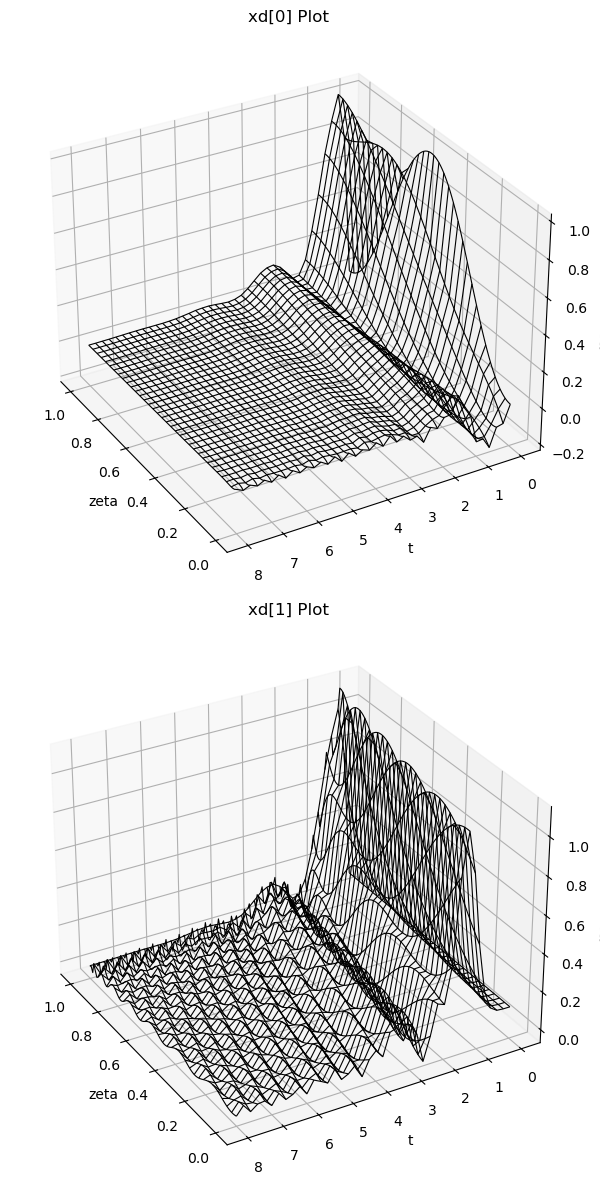

In [8]:
# Create t_grid and z_grid for meshgrid
t_grid, z_grid = np.meshgrid(t_eval_d, zeta)

# Create a figure for xd[0] and xd[1] wireframe plots
fig = plt.figure(figsize=(6,12))
azim_angle = 150
# Plot xd[0]
ax1 = fig.add_subplot(211, projection='3d')
ax1.view_init(azim=azim_angle)  # For xd[0] plot
ax1.plot_wireframe(z_grid, t_grid, x_MPC[0], color='black', linewidth=0.8, rstride=3, cstride=1)
ax1.set_title('xd[0] Plot')
ax1.set_ylabel('t')
ax1.set_xlabel('zeta')
ax1.set_zlabel('xd[0]')

# Plot xd[1]
ax2 = fig.add_subplot(212, projection='3d')
ax2.view_init(azim=azim_angle)  # For xd[1] plot
ax2.plot_wireframe(z_grid, t_grid, x_MPC[1], color='black', linewidth=0.8, rstride=3, cstride=1)
ax2.set_title('xd[1] Plot')
ax2.set_ylabel('t')
ax2.set_xlabel('zeta')
ax2.set_zlabel('xd[1]')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



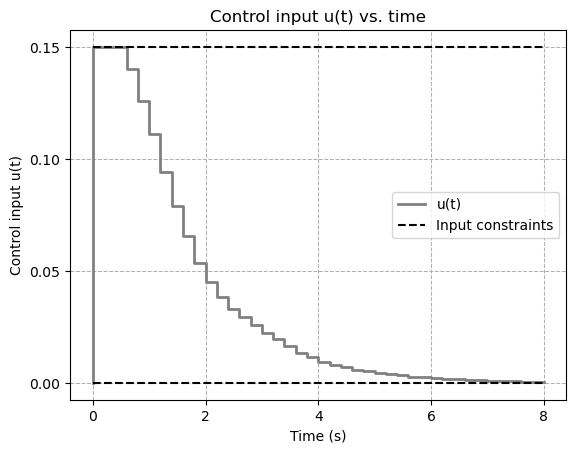

In [9]:
plt.step(t_eval_d, U_MPC, where='pre', color='gray', linewidth=2)  # Change to stairs plot
plt.plot(t_eval_d, np.ones_like(t_eval_d)*u_limits[0], 'k--')
plt.plot(t_eval_d, np.ones_like(t_eval_d)*u_limits[1], 'k--')
plt.grid(which='both', linestyle='--', linewidth=0.75)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(4))
plt.title('Control input u(t) vs. time')
plt.gca().set_xlabel('Time (s)')
plt.gca().set_ylabel('Control input u(t)')
plt.legend(['u(t)', 'Input constraints'])
plt.show()

In [ ]:
# plt.plot(t_eval_d[:len(x_MPC[0,-1,:])], x_MPC[1,-2,:])
# plt.plot(t_eval_d[:len(x_MPC[0,-1,:])], x_MPC[1,-1,:])
plt.plot(t_eval_d[:len(x_MPC[0,-1,:])], x_MPC[0,0,:])
plt.plot(t_eval_d[:len(x_MPC[0,-1,:])], x_MPC[0,1,:])
plt.plot(t_eval_d, np.zeros_like(t_eval_d), 'k-')
# plt.plot(t_eval_d, np.ones_like(t_eval_d)*y_limits[0], 'r--')
# plt.plot(t_eval_d, np.ones_like(t_eval_d)*y_limits[1], 'r--')
# plt.plot(t_eval_d, x_MPC[1,-1,:])
# plt.plot(t_eval_d, x_MPC[1,20,:])

In [ ]:
q_ctrl = 1
rrr = []
N_upper = 15
for N in range(1,N_upper,1):
    print(f'N = {N}')
    G = G_S_Su(zeta, s, par, q_ctrl, N, 0, lambdas, n_modes, normal_coefs)[0]
    r_ctrl = find_smallest_r(G, 0, 0, 10*q_ctrl)
    print(f'        q_ctrl = {q_ctrl}, r_ctrl = {r_ctrl:.2f}. Ratio = {(r_ctrl/q_ctrl):.2f}')
    rrr.append(r_ctrl)

fig, ax1 = plt.subplots()
ax1.scatter(range(1, N_upper, 1), rrr, color='blue')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('rrr values', color='blue')
ax2 = ax1.twinx()
ax2.scatter(range(1, N_upper, 1), rrr/np.array(range(1, N_upper, 1)), color='red')
ax2.set_ylabel('rrr / range(1, N_upper)', color='red')
plt.show()

In [ ]:
plt.plot(zeta[:len(x_MPC[0,:,-1])], x_MPC[1,:,5])